<a href="https://colab.research.google.com/github/hypnotoadie/minard/blob/main/Minard_Plot_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!apt-get install -q libgeos
!apt-get install -q libgeos-dev
!pip install -q basemap
# !pip install -q pyproj==1.9.6

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.10.2-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from folium import plugins
from matplotlib import image as mpimg
from mpl_toolkits.basemap import Basemap

## Pull Data

Luckily, there is a dataset already created for this visualization.

In [ ]:
!wget https://raw.githubusercontent.com/joannecheng/napoleon_analysis/master/cities.txt
!wget https://raw.githubusercontent.com/joannecheng/napoleon_analysis/master/temps.txt
!wget https://raw.githubusercontent.com/joannecheng/napoleon_analysis/master/troops.txt

--2023-10-27 17:54:48--  https://raw.githubusercontent.com/joannecheng/napoleon_analysis/master/cities.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 421 [text/plain]
Saving to: ‘cities.txt.1’

cities.txt.1        100%[===================>]     421  --.-KB/s    in 0s      

2023-10-27 17:54:48 (21.9 MB/s) - ‘cities.txt.1’ saved [421/421]

--2023-10-27 17:54:48--  https://raw.githubusercontent.com/joannecheng/napoleon_analysis/master/temps.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307 [text/plain]
Saving to: ‘temps.t

In [ ]:
# Reading cities data
cities_df = pd.read_csv('cities.txt', delim_whitespace=True)
# Reading temperatures data
temps_df = pd.read_csv('temps.txt', delim_whitespace=True)
# Reading troops data
troops_df = pd.read_csv('troops.txt', delim_whitespace=True)


In [ ]:
print("Cities Data:")
print(cities_df.head())

print("\nTemperatures Data:")
print(temps_df.head())

print("\nTroops Data:")
print(troops_df.head())

Cities Data:
   long   lat       city
0  24.0  55.0      Kowno
1  25.3  54.7      Wilna
2  26.4  54.4   Smorgoni
3  26.8  54.3  Moiodexno
4  27.7  55.2  Gloubokoe

Temperatures Data:
   long  temp month  day       date
0  37.6     0   Oct   18  18OCT1812
1  36.0     0   Oct   24  24OCT1812
2  33.2    -9   Nov    9  09NOV1812
3  32.0   -21   Nov   14  14NOV1812
4  29.2   -11   Nov   24  24NOV1812

Troops Data:
   long   lat  survivors direction  group
0  24.0  54.9     340000         A      1
1  24.5  55.0     340000         A      1
2  25.5  54.5     340000         A      1
3  26.0  54.7     320000         A      1
4  27.0  54.8     300000         A      1


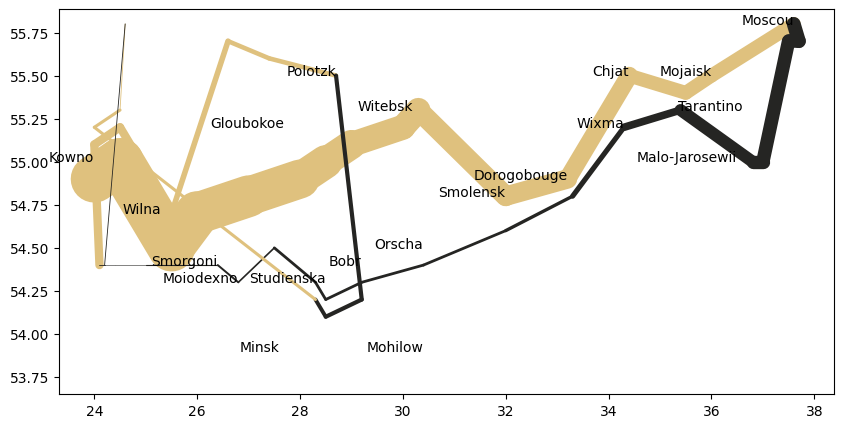

In [ ]:
# Color mapping
direction_colors = {'A': '#DFC17E','R': '#252523'}

plt.figure(figsize=(10, 5))

for i in range(1, len(troops_df)):
    x = [troops_df.loc[i-1, 'long'], troops_df.loc[i, 'long']]
    y = [troops_df.loc[i-1, 'lat'], troops_df.loc[i, 'lat']]
    lw = troops_df.loc[i, 'survivors'] / 10000.0
    color = direction_colors.get(troops_df.loc[i, 'direction'], 'black')  # Default to black if direction is unknown

    plt.plot(x, y, linewidth=lw, color=color, solid_capstyle='round')

# Annotate each city on the plot
for index, row in cities_df.iterrows():
    plt.text(row['long'], row['lat'], row['city'], fontsize=10, ha='right')

# Find the minimum latitude value in cities_df
min_lat = cities_df['lat'].min()

# Set the limits for Y-axis to create extra space at the bottom
plt.ylim(min_lat - 0.25, plt.ylim()[1])  # Decrease the minimum Y-axis limit by 1

plt.show()

## Overlaying on a Basemap in Python

This section breaks down due to the need to align coordinate systems in a way that will facilitate plotting. The Minard map doesn't define a coordinate system but seems to be an equidistant projection so I am trying to use EPSG:4326 to project it. However, the plot fails when I try to overlay with a basemap because

In [ ]:

# Convert cities_df and troops_df to GeoDataFrames
cities_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df.long, cities_df.lat))
troops_gdf = gpd.GeoDataFrame(troops_df, geometry=gpd.points_from_xy(troops_df.long, troops_df.lat))

# Set the CRS for both GeoDataFrames
cities_gdf.crs = "EPSG:4326"
troops_gdf.crs = "EPSG:4326"


In [ ]:
# Re-project to an equidistant projection
eqd_crs = "+proj=aeqd +lat_0=55 +lon_0=30"
cities_eqd = cities_gdf.to_crs(eqd_crs)
troops_eqd = troops_gdf.to_crs(eqd_crs)




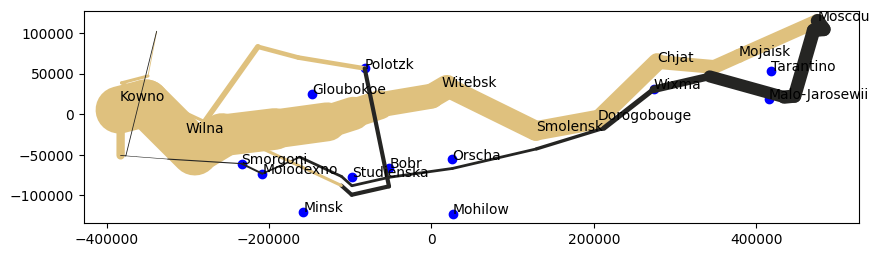

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot cities
cities_eqd.plot(ax=ax, color='blue')



# Plot troop movements
for i in range(1, len(troops_eqd)):
    x = [troops_eqd.loc[i-1, 'geometry'].x, troops_eqd.loc[i, 'geometry'].x]
    y = [troops_eqd.loc[i-1, 'geometry'].y, troops_eqd.loc[i, 'geometry'].y]
    lw = troops_eqd.loc[i, 'survivors'] / 10000.0
    color = direction_colors.get(troops_df.loc[i, 'direction'], 'black')

    ax.plot(x, y, linewidth=lw, color=color, solid_capstyle='round')

    # Label cities
for x, y, label in zip(cities_eqd.geometry.x, cities_eqd.geometry.y, cities_eqd['city']):
    ax.text(x, y, label)

plt.show()

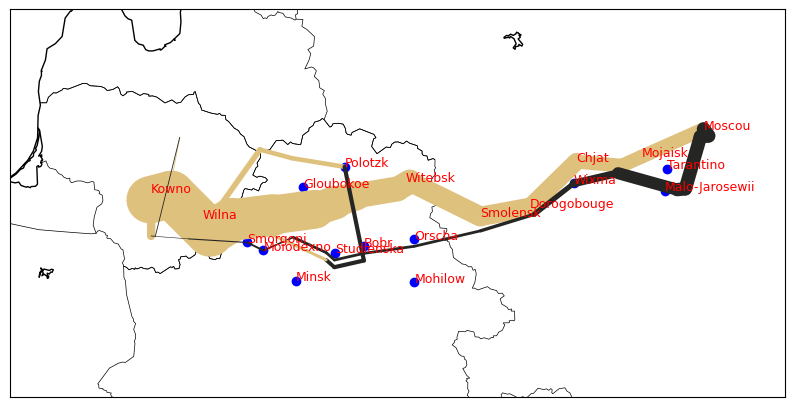

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Define the Basemap parameters
m = Basemap(
    projection='aeqd',
    lat_0=55,
    lon_0=30,
    width=1200000,
    height=600000,
    ax=ax,
    resolution='i'  # intermediate resolution
)

# Draw boundaries, coastlines, and countries
m.drawcoastlines()
m.drawcountries()

# Project cities
city_x, city_y = m(cities_gdf['long'].values, cities_gdf['lat'].values)

# Plot cities
ax.scatter(city_x, city_y, color='blue')

# Plot troop movements
for i in range(1, len(troops_gdf)):
    x, y = m([troops_gdf.loc[i-1, 'long'], troops_gdf.loc[i, 'long']],
             [troops_gdf.loc[i-1, 'lat'], troops_gdf.loc[i, 'lat']])
    lw = troops_gdf.loc[i, 'survivors'] / 10000.0
    color = direction_colors.get(troops_df.loc[i, 'direction'], 'black')

    ax.plot(x, y, linewidth=lw, color=color, solid_capstyle='round')

# Label cities
for x, y, label in zip(city_x, city_y, cities_gdf['city']):
    ax.text(x, y, label, color='red', fontsize=9)

# Show the plot
plt.show()